In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from IPython.display import display, Latex

from matplotlib.ticker import LogLocator

os.environ['PATH'] = os.environ['PATH'] + ':' + os.path.expanduser('~/texlive/2025/bin/x86_64-linux/')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

sns.set_style("whitegrid")
sns.set_palette("husl")

In [3]:
datasets = ['adult', 'folktables', 'hmda']
dataset_names = {'adult': 'Adult', 'folktables': 'Folktables', 'hmda': 'HMDA'}

# model_classes = ['logistic', 'RF', 'mlp', 'gbt', 'svm']
model_classes = ['logistic', 'RF', 'gbt']
model_class_names = {'logistic': 'Logistic Regression', 'RF': 'Random Forest', 'gbt': 'Gradient Boosted Trees', 'knn': 'K-Nearest Neighbors'}

model_classes_extended = model_classes + ["fl_" + model_class for model_class in model_classes]
model_classes_extended_names = model_class_names.copy()
for model_class in model_classes:
    model_classes_extended_names["fl_" + model_class] = "Fairlearn " + model_class_names[model_class]



In [4]:
def plot_cei_comparison(ax, dataset, model_class, with_mrl_assm, max_num_datasets):

    est_means = np.zeros(T)
    true_cei_means = np.zeros(T)
    est_sds = np.zeros(T)
    true_cei_sds = np.zeros(T)
    hi_est = np.zeros(T)
    lo_est = np.zeros(T)
    hi_true_cei = np.zeros(T)
    lo_true_cei = np.zeros(T)

    for i in range(max_num_datasets):
        derived_data_fname = f'algo_data/{dataset}_{model_class}_{i}.csv' if not with_mrl_assm else f'algo_data/{dataset}_{model_class}_mrl_{i}.csv'
        if not os.path.exists(derived_data_fname):
            print(f"File {derived_data_fname} does not exist")
            continue
        derived_data = pd.read_csv(derived_data_fname)

        est_var_prefix = "no_assm_" if not with_mrl_assm else "mrl_assm_"

        est_means += pd.to_numeric(derived_data[est_var_prefix + 'means'])
        true_cei_means += pd.to_numeric(derived_data['true_cei_means'])
        est_sds += pd.to_numeric(derived_data[est_var_prefix + 'sds'])
        true_cei_sds += pd.to_numeric(derived_data['true_cei_sds'])

    est_means /= max_num_datasets
    true_cei_means /= max_num_datasets
    est_sds /= max_num_datasets
    true_cei_sds /= max_num_datasets

    hi_est = pd.to_numeric(est_means + est_sds)
    lo_est = pd.to_numeric(est_means - est_sds)
    hi_true_cei = pd.to_numeric(true_cei_means + true_cei_sds)
    lo_true_cei = pd.to_numeric(true_cei_means - true_cei_sds)

    # sns.lineplot(x=range(1, T+1), y=est_means, label=r'Upper bound ($\bar\mu(\hat U_t) \cdot \bar p_t(\delta)$)', linewidth=2.5, ax=ax, legend=False)
    sns.lineplot(x=range(1, T+1), y=est_means, linewidth=2.5, ax=ax, legend=False)
    ax.fill_between(range(1, T+1), lo_est, hi_est, alpha=0.2)
    # sns.lineplot(x=range(1, T+1), y=true_cei_means, label=r'Full information ($g(\hat U_t)$)', linewidth=2.5, ax=ax, legend=False)
    sns.lineplot(x=range(1, T+1), y=true_cei_means, linewidth=2.5, ax=ax, legend=False)
    ax.fill_between(range(1, T+1), lo_true_cei, hi_true_cei, alpha=0.2)
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[], numticks=5))
    ax.set_ylabel('')
    ax.set_xlabel('')
    # ylower = 10e-6
    # if dataset in ['adult']:
    #     ax.set_ylim(ylower, 0.6)
    # elif dataset in ['folktables']:
    #     ax.set_ylim(ylower, 0.6)
    # else:
    #     ax.set_ylim(ylower, 0.6)
    ax.set_xlim(1, T)


def plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=1, fairlearn=False):
    fig, axes = plt.subplots(3, len(model_classes), figsize=(19, 10))

    for j, dataset in enumerate(datasets):
        for i, model_class in enumerate(model_classes):
            mc = model_class if not fairlearn else "fl_" + model_class
            plot_cei_comparison(axes[j][i], dataset, mc, with_mrl_assm, max_num_datasets)

    bigfont = 20
    smallerfont = 17
    fig.supxlabel('Iteration', fontsize=bigfont)
    fig.supylabel('Marginal Gain', fontsize=bigfont, x=-0.005)

    for i, model_class in enumerate(model_classes):
        mc_name = model_class_names[model_class] if not fairlearn else "Fairlearn " + model_class_names[model_class]
        axes[0][i].set_title(mc_name, fontsize=smallerfont)

    for i, ds in enumerate(datasets):
        axes[i][0].set_ylabel(dataset_names[ds], fontsize=smallerfont)


    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.53, 1.12), ncol=3, fontsize=bigfont, frameon=True, fancybox=True, shadow=True)

    fig.tight_layout()
    
    fig_fname_postfix = "" if not with_mrl_assm else "_mrl"
    fig_fname_postfix += "" if not fairlearn else "_fairlearn"
    fig.savefig(f'cei_comparison{fig_fname_postfix}.svg', format='svg', dpi=300, bbox_inches='tight')


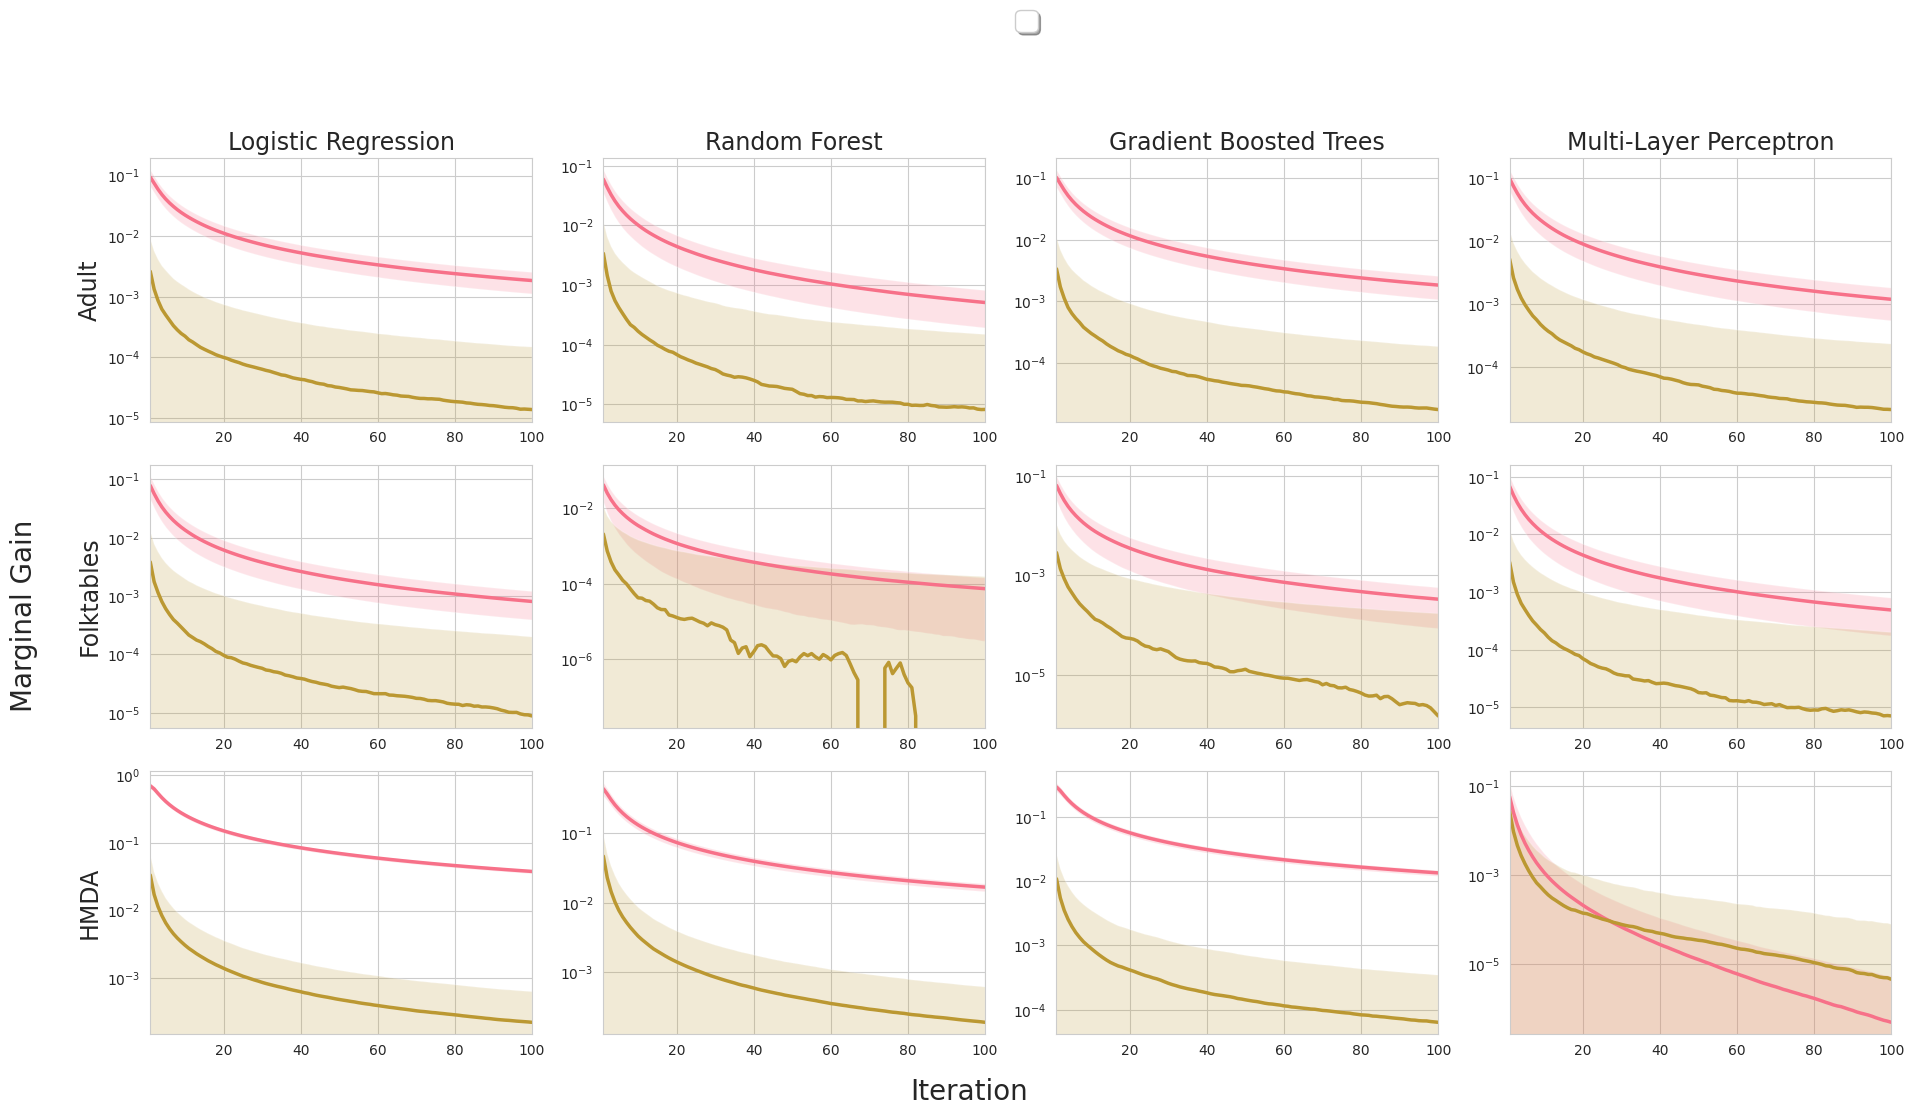

In [4]:
delta = 0.05
T = 100 # number of model training iterations
max_num_datasets = 35
plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=max_num_datasets, fairlearn=False)


File algo_data/folktables_fl_gbt_17.csv does not exist
File algo_data/folktables_fl_gbt_18.csv does not exist
File algo_data/folktables_fl_gbt_19.csv does not exist
File algo_data/folktables_fl_gbt_20.csv does not exist
File algo_data/folktables_fl_gbt_21.csv does not exist
File algo_data/folktables_fl_gbt_22.csv does not exist
File algo_data/folktables_fl_knn_17.csv does not exist
File algo_data/folktables_fl_knn_18.csv does not exist
File algo_data/folktables_fl_knn_19.csv does not exist
File algo_data/folktables_fl_knn_20.csv does not exist
File algo_data/folktables_fl_knn_21.csv does not exist
File algo_data/folktables_fl_knn_22.csv does not exist
File algo_data/hmda_fl_gbt_17.csv does not exist
File algo_data/hmda_fl_gbt_18.csv does not exist
File algo_data/hmda_fl_gbt_19.csv does not exist
File algo_data/hmda_fl_gbt_20.csv does not exist
File algo_data/hmda_fl_gbt_21.csv does not exist
File algo_data/hmda_fl_gbt_22.csv does not exist
File algo_data/hmda_fl_knn_17.csv does not exi

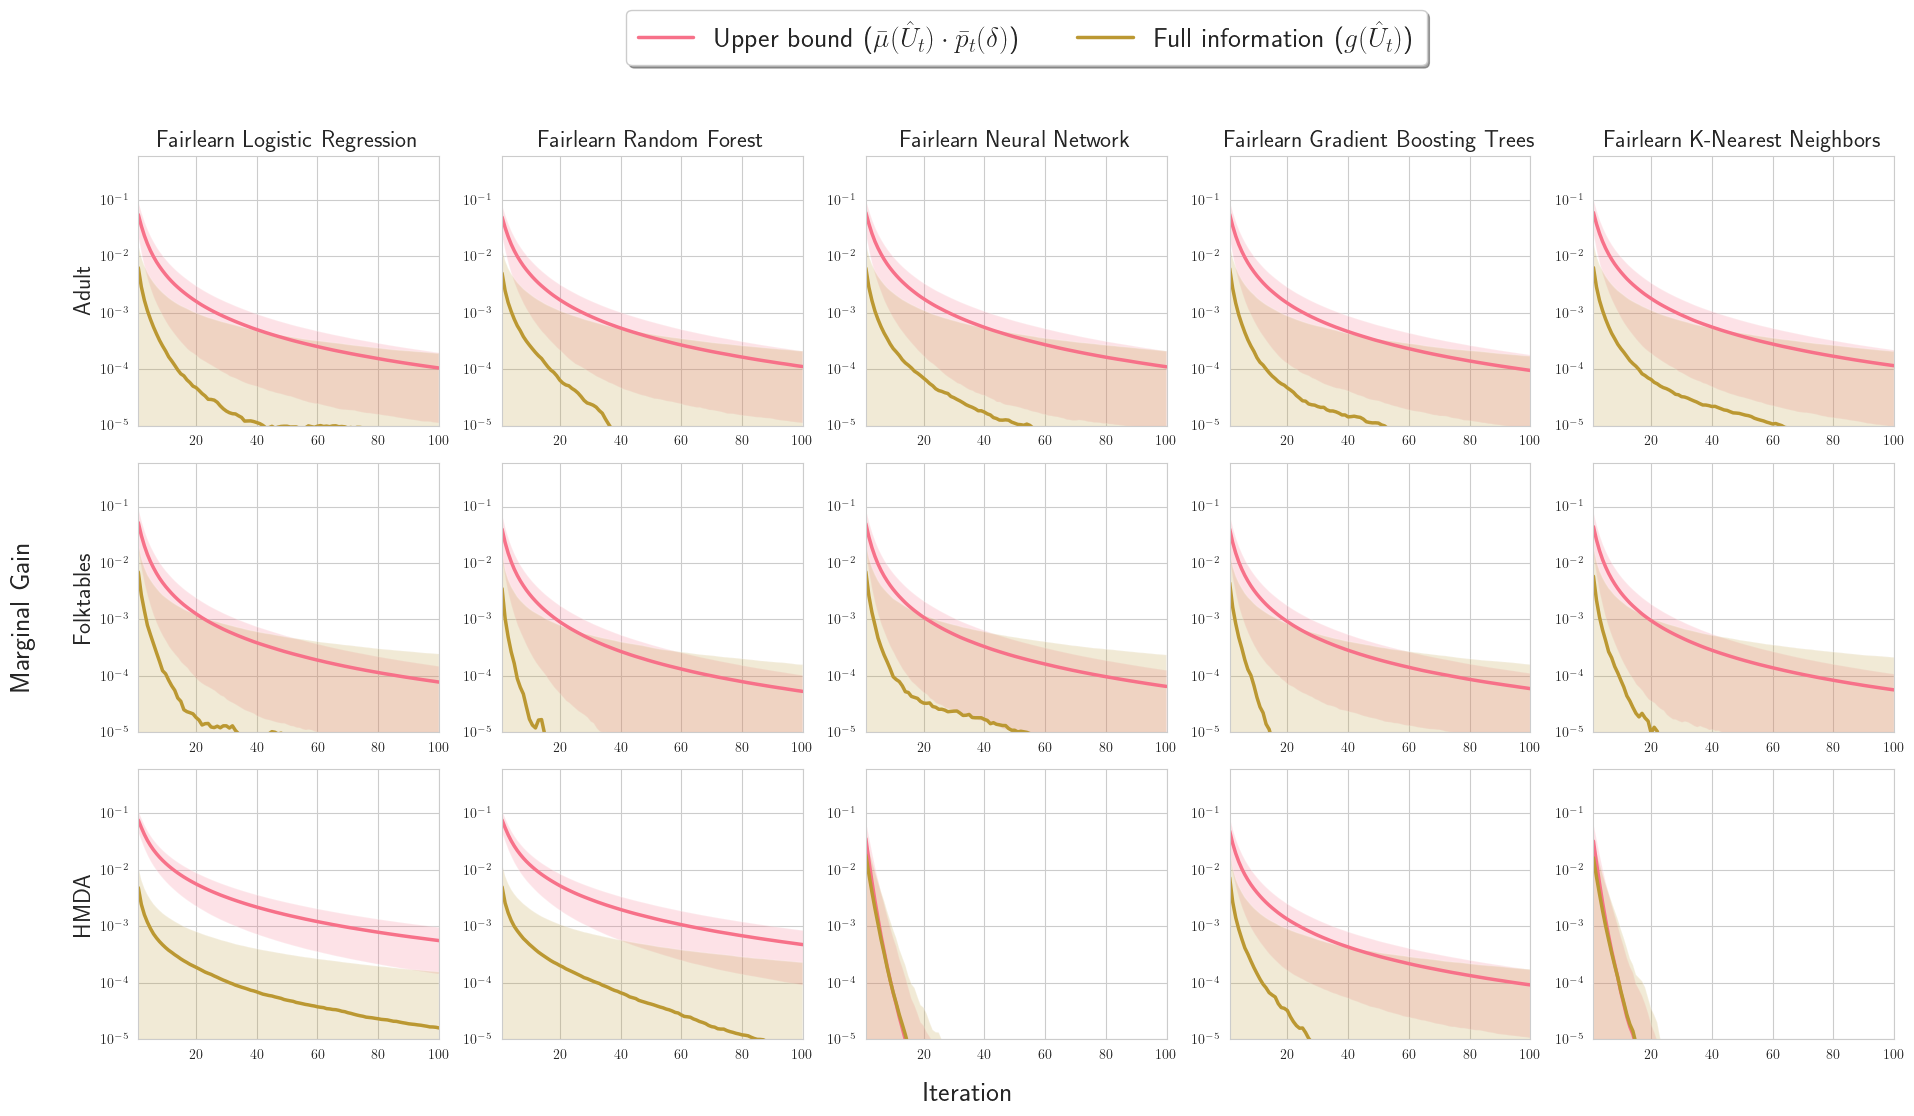

In [93]:
plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=max_num_datasets, fairlearn=True)


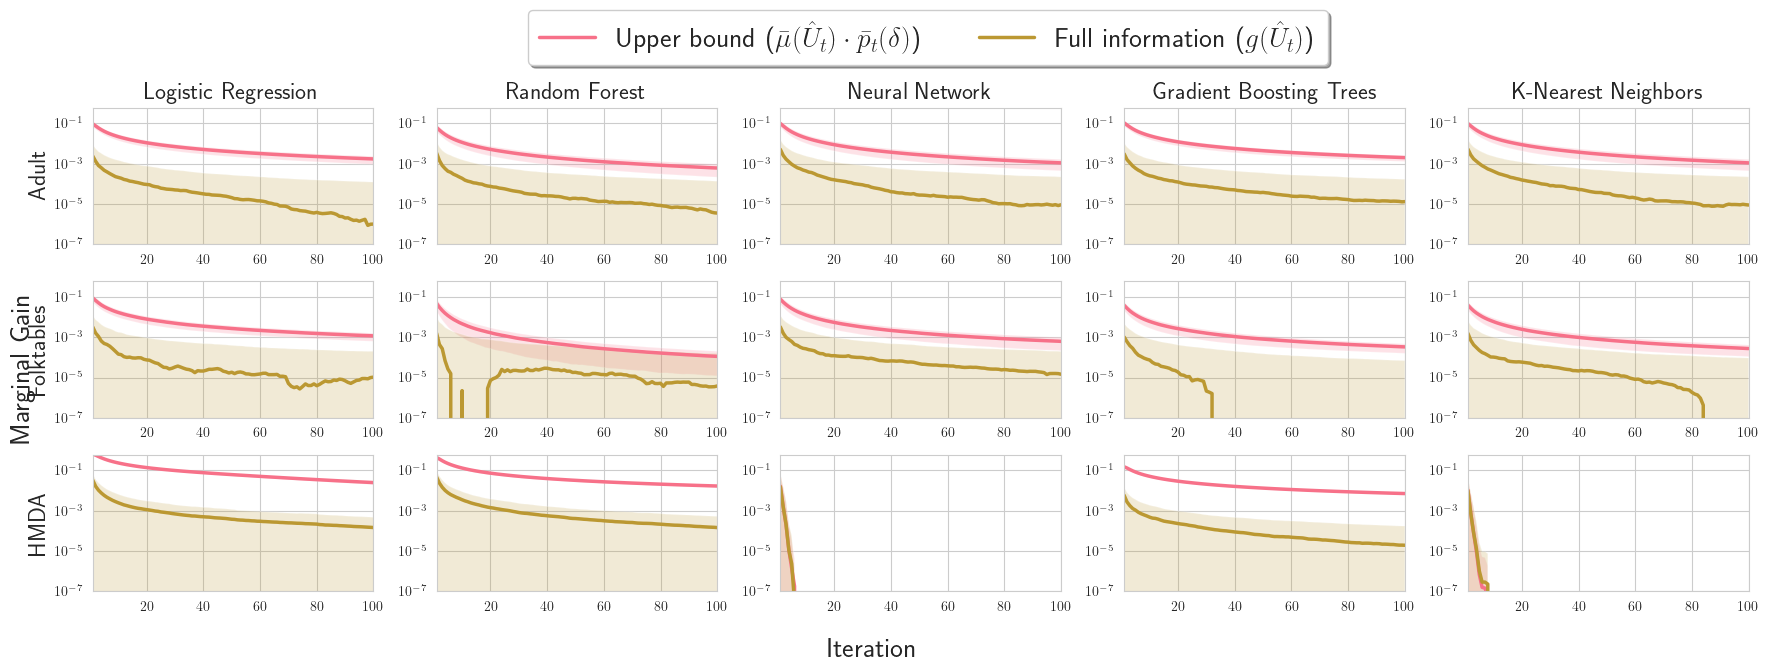

In [24]:
plot_cei_comparison_all(with_mrl_assm=True, max_num_datasets=max_num_datasets, fairlearn=False)


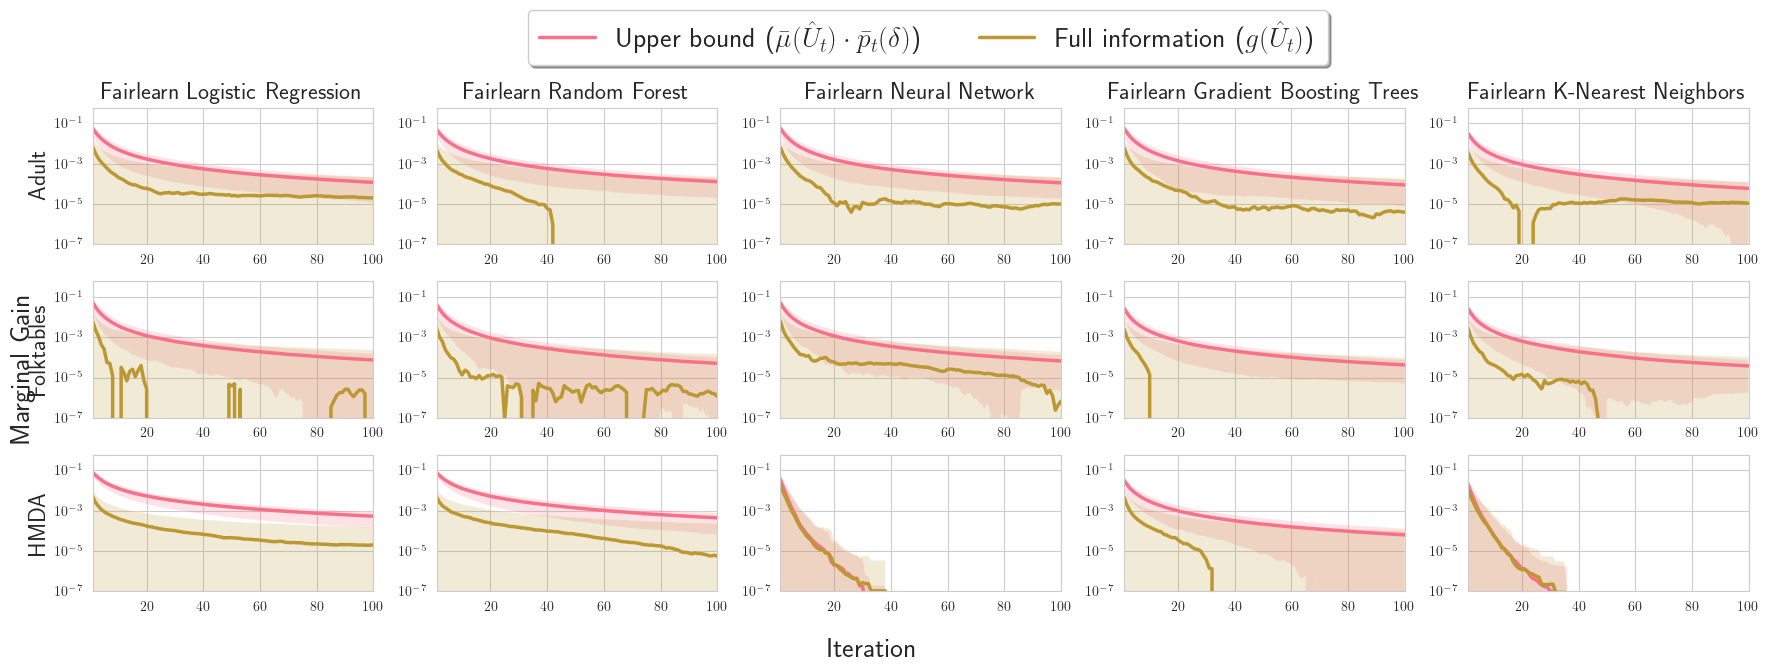

In [23]:
plot_cei_comparison_all(with_mrl_assm=True, max_num_datasets=max_num_datasets, fairlearn=True)

In [19]:
max_num_datasets = 50
srg_rows = []
accuracy_rows = []
miscoverage_rows = []

model_classes_extended = model_classes # + ["fl_" + model_class for model_class in model_classes]
model_classes_extended_names = model_class_names.copy()
for model_class in model_classes:
    model_classes_extended_names["fl_" + model_class] = "Fairlearn " + model_class_names[model_class]


srg_means = {}
srg_stds = {}
accuracy_means = {}
accuracy_stds = {}
miscoverage = {}

for dataset in datasets:
    print(dataset)
    srg_means[dataset] = np.zeros(len(model_classes_extended))
    srg_stds[dataset] = np.zeros(len(model_classes_extended))
    accuracy_means[dataset] = np.zeros(len(model_classes_extended))
    accuracy_stds[dataset] = np.zeros(len(model_classes_extended))
    miscoverage[dataset] = np.zeros(len(model_classes_extended))
    num_valid_files = 0
    for fileno in tqdm(range(max_num_datasets)):
        results = pd.read_csv(f'results_data/{dataset}_results_{fileno}.csv')

        try:
            srg_means_i = np.array([np.mean(results[f"{model_class}_df_SRG"]) for model_class in model_classes_extended])
            srg_stds_i = np.array([np.std(results[f"{model_class}_df_SRG"]) for model_class in model_classes_extended])
            accuracy_means_i = np.array([np.mean(results[f"{model_class}_df_accuracy"]) for model_class in model_classes_extended])
            accuracy_stds_i = np.array([np.std(results[f"{model_class}_df_accuracy"]) for model_class in model_classes_extended])
            num_valid_files += 1
        except:
            print(f'File not found: results_data/{dataset}_results_{fileno}.csv')
            continue

        srg_means[dataset] += srg_means_i
        srg_stds[dataset] += srg_stds_i
        accuracy_means[dataset] += accuracy_means_i
        accuracy_stds[dataset] += accuracy_stds_i

    srg_means[dataset] /= num_valid_files
    srg_stds[dataset] /= num_valid_files
    accuracy_means[dataset] /= num_valid_files

for i, model_class in enumerate(model_classes_extended):
    srg_rows.append(f"{model_classes_extended_names[model_class]} & " + " & ".join([f"{srg_means[dataset][i]:0.3f} ({srg_stds[dataset][i]:0.3f})" for dataset in datasets]) + " \\")
    accuracy_rows.append(f"{model_classes_extended_names[model_class]} & " + " & ".join([f"{accuracy_means[dataset][i]:0.3f} ({accuracy_stds[dataset][i]:0.3f})" for dataset in datasets]) + " \\")

srg_rows = "".join(srg_rows)
accuracy_rows = "".join(accuracy_rows)


adult


100%|██████████| 50/50 [00:05<00:00,  9.80it/s]


folktables


100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


hmda


100%|██████████| 50/50 [00:02<00:00, 22.67it/s]


In [5]:
def display_table(rows):
    print("LaTeX Table:")
    print("\\begin{tabular}{lccc}")
    print("Model & Adult & Folktables & HMDA \\\\")
    print(rows.replace("\\", "\\\\\n"))
    print("\\end{tabular}")
    display(Latex(r"\begin{array}{lccc}" + "\n" +
                r"\text{Model} & \text{Adult} & \text{Folktables} & \text{HMDA} \\" + "\n" +
                rows.replace("\\", r"\\") +
                r"\end{array}"))

display_table(accuracy_rows)

NameError: name 'accuracy_rows' is not defined

In [ ]:
display_table(srg_rows)

LaTeX Table:
\begin{tabular}{lccc}
Model & Adult & Folktables & HMDA \\
Logistic Regression & 0.095 (0.011) & 0.072 (0.015) & 0.704 (0.060) \\
Random Forest & 0.061 (0.013) & 0.033 (0.014) & 0.453 (0.084) \\
Gradient Boosted Trees & 0.108 (0.013) & 0.061 (0.013) & 0.300 (0.027) \\
Multi-Layer Perceptron & 0.101 (0.017) & 0.063 (0.015) & 0.053 (0.053) \\

\end{tabular}


<IPython.core.display.Latex object>

In [40]:
miscovered_means = {}

max_file_no = 50  # set to 50 according to context above

for dataset in datasets:
    for model_class in model_classes_extended:
        miscovered_entries = []
        for fileno in range(max_file_no):
            file_path = f'algo_data/{dataset}_{model_class}_{fileno}.csv'
            try:
                df = pd.read_csv(file_path)
                # Assumes that the first entry is in row 0, column 'miscovered'
                if 'miscovered' in df.columns:
                    miscovered_entries.append(df.loc[0, 'miscovered'])
            except Exception as e:
                # If the file does not exist or is malformed, skip it
                continue
        if len(miscovered_entries) > 0:
            avg_miscovered = sum(miscovered_entries) / len(miscovered_entries)
        else:
            avg_miscovered = np.nan
        miscovered_means[dataset + "_" + model_class] = avg_miscovered


In [41]:
# Create and display a LaTeX table of "miscovered_means" where columns are datasets and rows are methods (model_classes_extended).
def miscovered_table(miscovered_means, datasets, model_classes_extended):
    # Prepare table rows as LaTeX-formatted string
    rows = ""
    for model_class in model_classes_extended:
        row = [model_classes_extended_names[model_class]]
        for dataset in datasets:
            key = f"{dataset}_{model_class}"
            val = miscovered_means.get(key, np.nan)
            if val is None or np.isnan(val):
                disp_val = "-"
            else:
                disp_val = f"{val:.3f}"
            row.append(disp_val)
        rows += " & ".join(row) + r" \\" + "\n"
    # Print LaTeX table
    print("LaTeX Table:")
    print("\\begin{tabular}{l" + "c"*len(datasets) + "}")
    print("Method & " + " & ".join(datasets) + r" \\")
    print(rows)
    print("\\end{tabular}")
    # Display as Latex in notebook
    header = r"\text{Method} & " + " & ".join(r"\text{" + d + "}" for d in datasets) + r" \\"
    display(Latex(r"\begin{array}{l" + "c"*len(datasets) + "}" + "\n" +
                  header + "\n" +
                  rows.replace("\\", r"\\") +
                  r"\end{array}"))

# Actually display the table
miscovered_table(miscovered_means, datasets, model_classes_extended)


LaTeX Table:
\begin{tabular}{lccc}
Method & adult & folktables & hmda \\
Logistic Regression & 0.002 & 0.102 & 0.000 \\
Random Forest & 0.020 & 0.263 & 0.000 \\
Gradient Boosted Trees & 0.000 & 0.102 & 0.000 \\
Multi-Layer Perceptron & 0.022 & 0.132 & 0.383 \\
Fairlearn Logistic Regression & - & - & - \\
Fairlearn Random Forest & - & - & - \\
Fairlearn Gradient Boosted Trees & - & - & - \\
Fairlearn Multi-Layer Perceptron & - & - & - \\

\end{tabular}


<IPython.core.display.Latex object>

In [8]:
max_num_datasets = 10

srg_dct = {}
acc_dct = {}
acc_max = 0
srg_max = 0
acc_min = 1
srg_min = 1


for dataset in datasets:
    for model_class in model_classes:
        srg_all = []
        acc_all = []
        for fileno in range(max_num_datasets):

            file_path = f'results_data/{dataset}_results_{fileno}.csv'
            results = pd.read_csv(f'results_data/{dataset}_results_{fileno}.csv')

            acc = results[f"{model_class}_df_accuracy"]
            srg = results[f"{model_class}_df_SRG"]

            srg_all.append(np.array(srg))
            acc_all.append(np.array(acc))
            acc_max = max(acc_max, np.max(acc))
            srg_max = max(srg_max, np.max(srg))
            acc_min = min(acc_min, np.min(acc))
            srg_min = min(srg_min, np.min(srg))


        srg_dct[dataset + "_" + model_class] = np.concatenate(srg_all)
        acc_dct[dataset + "_" + model_class] = np.concatenate(acc_all)





KeyError: 'adult_fl_logistic'

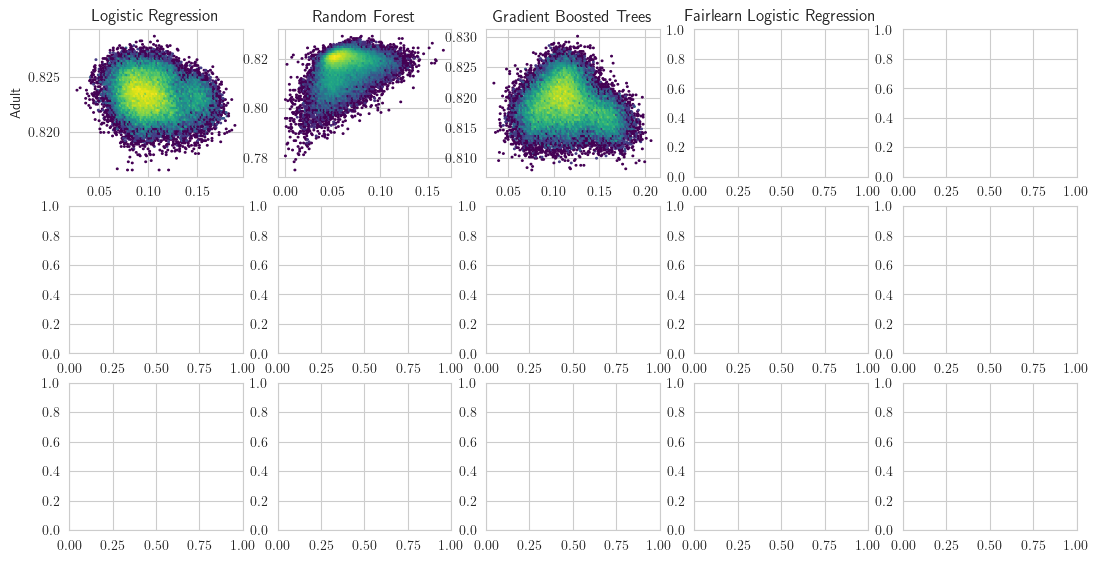

In [9]:
def plot_accuracy_srg_comparison(fairlearn=False):
    fig, axes = plt.subplots(3, 5, figsize=(13, 6.5))
    for j, dataset in enumerate(datasets):
        for i, model_class in enumerate(model_classes_extended):
            model_class = model_class if not fairlearn else "fl_" + model_class
            if j == 0:
                axes[0, i].set_title(model_classes_extended_names[model_class])
            if i == 0:
                axes[j, 0].set_ylabel(dataset_names[dataset])
            axes[j, i].hexbin(srg_dct[dataset + "_" + model_class], acc_dct[dataset + "_" + model_class], bins='log', gridsize=100, cmap='viridis')
            # if j <= 1:
            #     axes[j, i].set_ylim(0.75, 0.95)
            #     axes[j, i].set_xlim(0, 0.20)
            # else:
            #     axes[j, i].set_ylim(0.5, 0.7)
            #     axes[j, i].set_xlim(left=0)
    fig.supxlabel('Disparate Impact')
    fig.supylabel('Accuracy')
    fig.tight_layout()
    return fig, axes

fig, axes = plot_accuracy_srg_comparison(fairlearn=False)
plt.savefig('accuracy_srg_comparison.png', format='png', dpi=300, bbox_inches='tight')

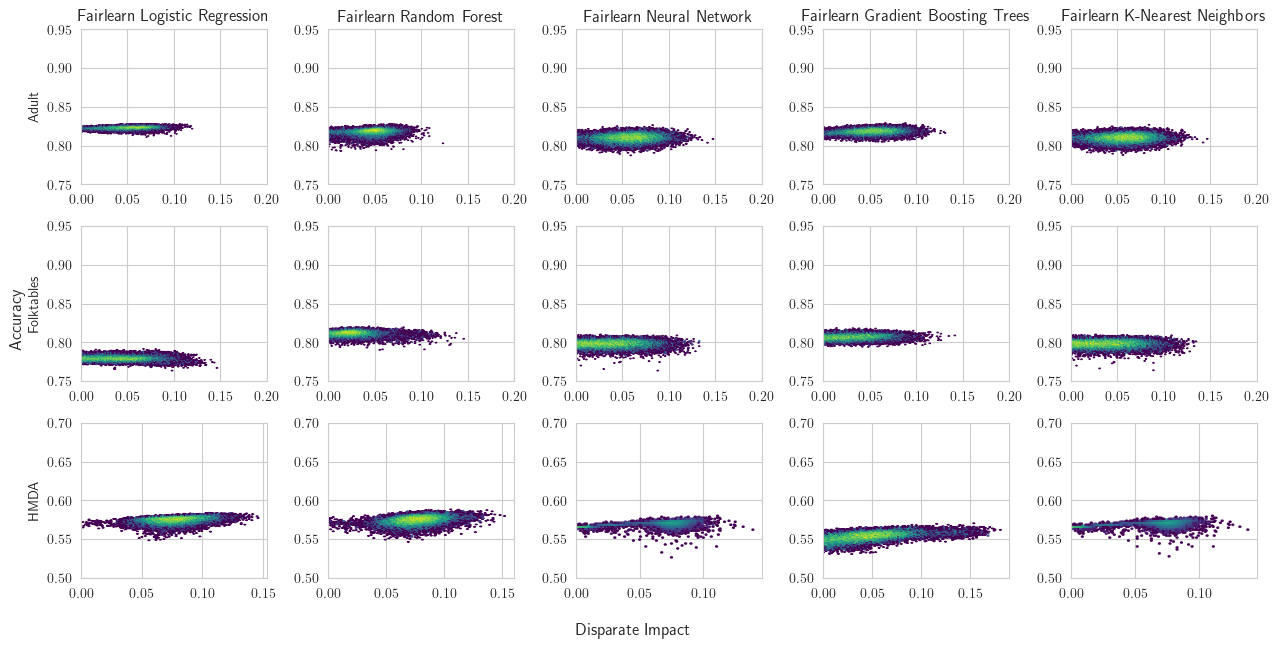

In [63]:
fig, axes = plot_accuracy_srg_comparison(fairlearn=True)
plt.savefig('accuracy_srg_comparison_fairlearn.png', format='png', dpi=300, bbox_inches='tight')

In [9]:
# Define range of files to process
slurm_file_indices = range(0, 51)  # slurm-0 to slurm-50 inclusive

# All datasets and model class keys, inferred from file patterns
datasets = ["adult", "folktables", "hmda"]
model_classes = ["logistic", "RF", "nn", "gbt", "knn", "fl_logistic", "fl_RF", "fl_nn", "fl_gbt", "fl_knn"]

# Prepare a dict to accumulate miscoverage values
miscoverage = {}
for dataset in datasets:
    for model_class in model_classes:
        key = f"{dataset} {model_class}"
        miscoverage[key] = []

# Parse each file
for idx in slurm_file_indices:
    filename = f"slurm-{idx}.out"
    if not os.path.isfile(filename):
        continue
    with open(filename, "r") as f:
        lines = f.readlines()
        i = 0
        while i < len(lines)-1:
            line = lines[i].strip()
            if line == '':
                i += 1
                continue
            # Look for "dataset model"
            parts = line.split()
            if len(parts) == 2:
                key = line
                # Next line should be the score if it exists and is a number
                if i + 1 < len(lines):
                    try:
                        value = float(lines[i+1].strip())
                        if key in miscoverage:
                            miscoverage[key].append(value)
                    except ValueError:
                        pass
            i += 1

# Compute averages for each (dataset, model)
miscoverage_mean = {}
for key, vals in miscoverage.items():
    if vals:
        miscoverage_mean[key] = np.mean(vals)
    else:
        miscoverage_mean[key] = np.nan  # mark missing

# Pretty-print results
print("Average miscoverage rate over slurm-0.out to slurm-50.out:\n")
table_lines = []
for model_class in model_classes_extended:
    row_entries = []
    # Row label
    row_label = model_classes_extended_names[model_class]
    for dataset in datasets:
        key = f"{dataset} {model_class}"
        val = miscoverage_mean.get(key, np.nan)
        if np.isnan(val):
            colstr = "---"
        else:
            colstr = f"{val:.3f}"
        row_entries.append(colstr)
    table_lines.append(f"{row_label} & " + " & ".join(row_entries) + " \\\\")
latex_table_str = "\n".join(table_lines)
print(latex_table_str)
import csv

# save results to CSV
csv_filename = "miscoverage_mean.csv"
with open(csv_filename, "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write header: Model Class, then dataset names
    header = ["Model"] + datasets
    writer.writerow(header)
    for model_class in model_classes_extended:
        row = [model_classes_extended_names[model_class]]
        for dataset in datasets:
            key = f"{dataset} {model_class}"
            val = miscoverage_mean.get(key, np.nan)
            if np.isnan(val):
                row.append("")
            else:
                row.append(f"{val:.3f}")
        writer.writerow(row)
print(f"\nSaved miscoverage results to {csv_filename}")




Average miscoverage rate over slurm-0.out to slurm-50.out:

Logistic Regression & 0.001 & 0.148 & 0.000 \\
Random Forest & 0.056 & 0.411 & 0.000 \\
Neural Network & 0.031 & 0.174 & 0.085 \\
Gradient Boosting Trees & 0.017 & 0.169 & 0.000 \\
K-Nearest Neighbors & 0.030 & 0.171 & 0.088 \\
Fairlearn Logistic Regression & 0.307 & 0.510 & 0.017 \\
Fairlearn Random Forest & 0.357 & 0.470 & 0.018 \\
Fairlearn Neural Network & 0.326 & 0.518 & 0.133 \\
Fairlearn Gradient Boosting Trees & 0.291 & 0.438 & 0.373 \\
Fairlearn K-Nearest Neighbors & 0.306 & 0.529 & 0.127 \\

Saved miscoverage results to miscoverage_mean.csv


# Investigating miscoverage

In [3]:
model = "RF"
dataset = "folktables"
fileno = 1
results = pd.read_csv(f'results_data/{dataset}_results_{fileno}.csv')
model_columns = [col for col in results.columns if model in col]
model_results = results[model_columns]


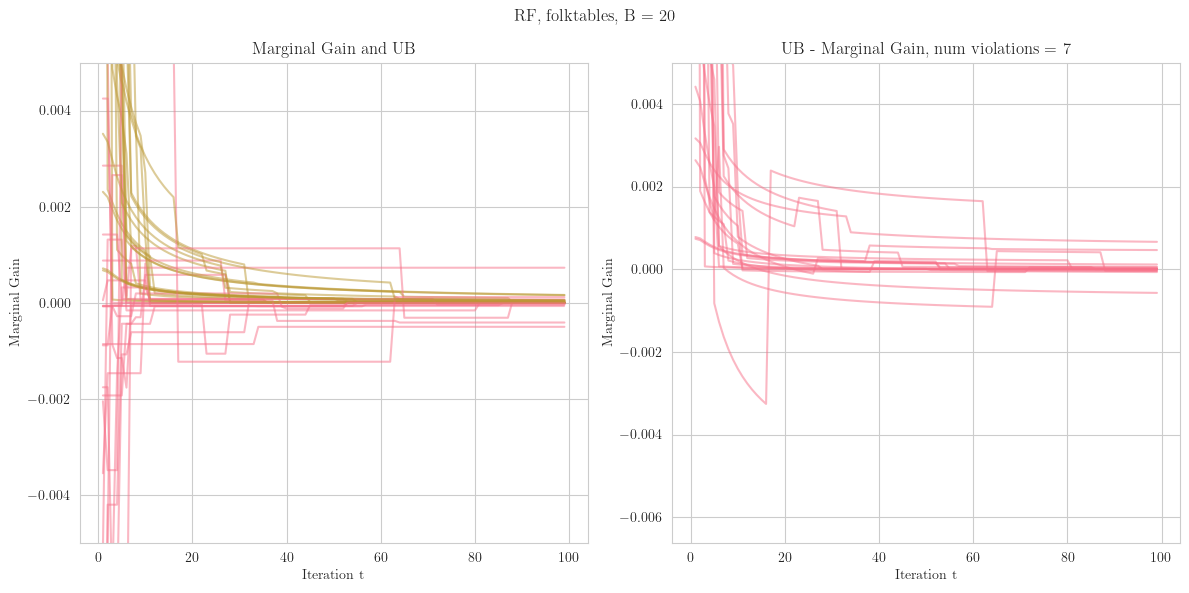

In [22]:
import copy
from algorithm import compute_expected_marginal_gain
import math

# Create a deep copy of model_results

T = 100
B = 20
num_violations = 0

delta = 0.05

p_bar = []
for t in range(1, T):
    if t == 1:
        p_t = 1 - math.exp(-1/delta)
    else:
        p_t = 1 - ((t - 1)/delta+ 1)**(-1/(t - 1))
    p_bar.append(p_t)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

for i in range(B):
    model_results_permuted = copy.deepcopy(model_results)
    model_results_permuted = model_results_permuted.sample(frac=1, replace=True).reset_index(drop=True)

    curr_best_inds = [np.argmin(model_results_permuted.loc[:t, f"{model}_eval_SRG"]) for t in range(1, T)]

    # Generate t values (x-axis)
    t_values = list(range(1, T))

    # Get the running best indices from above
    true_cei = [compute_expected_marginal_gain(model_results_permuted, model_results_permuted.loc[curr_best_inds[t-1], f"{model}_eval_SRG"], model_results_permuted.loc[curr_best_inds[t-1], f"{model}_df_SRG"], model) for t in t_values]
    ub = [p_bar[t-1]*model_results_permuted.loc[curr_best_inds[t-1], f"{model}_eval_SRG"] for t in t_values]
    axes[0].plot(t_values, true_cei, c='C0', alpha=0.5)
    axes[0].plot(t_values, ub, c='C1', alpha=0.5)
    gap = np.array(ub) - np.array(true_cei)
    axes[1].plot(t_values, gap, c='C0', alpha=0.5)
    num_violations += np.any(gap < 0)

for ax in axes:
    ax.set_xlabel("Iteration t")
    ax.set_ylabel("Marginal Gain")

axes[0].set_title(f"Marginal Gain and UB")
axes[1].set_title(f"UB - Marginal Gain, num violations = {num_violations}")
axes[1].set_ylim(top=0.005)
axes[0].set_ylim(top=0.005)
axes[0].set_ylim(bottom=-0.005)
fig.suptitle(f"{model}, {dataset}, B = {B}")
# plt.legend()
plt.tight_layout()
plt.show()







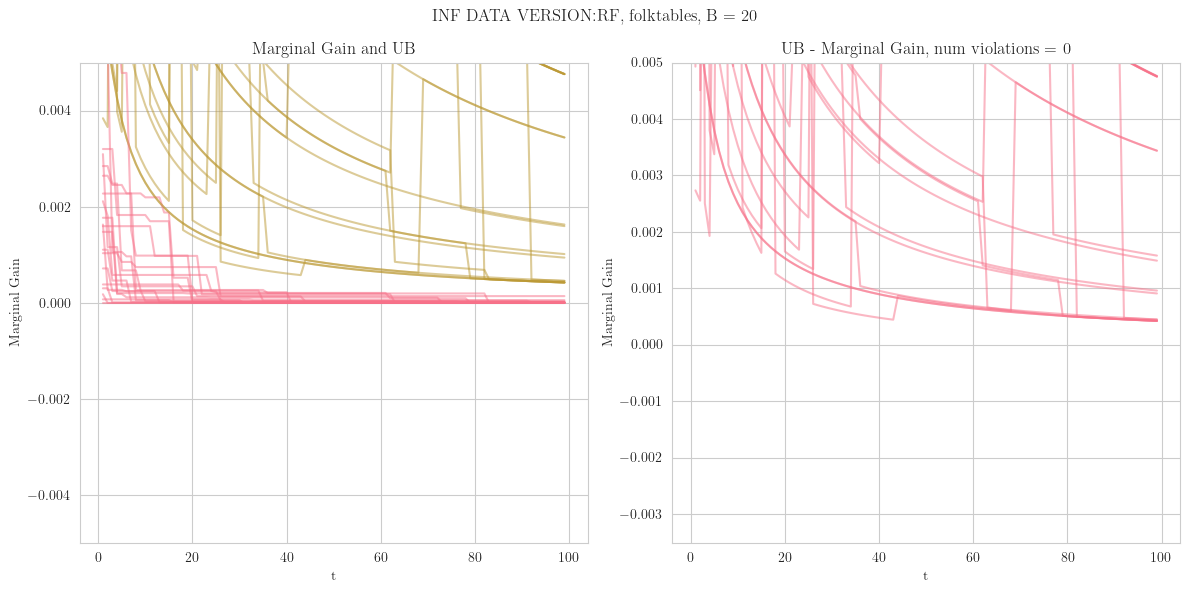

In [ ]:
# True data version

T = 100
B = 20
num_violations = 0

delta = 0.05


def inf_data_compute_expected_marginal_gain(df, u, true_u, model_class):
    filtered_rows = df[df[f'{model_class}_df_SRG'] < u]
    if len(filtered_rows) == 0:
        return 0
    return (true_u - filtered_rows[f'{model_class}_df_SRG'].mean()) * len(filtered_rows) / len(df)

p_bar = []
for t in range(1, T):
    if t == 1:
        p_t = 1 - math.exp(-1/delta)
    else:
        p_t = 1 - ((t - 1)/delta+ 1)**(-1/(t - 1))
    p_bar.append(p_t)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

for i in range(B):
    model_results_permuted = copy.deepcopy(model_results)
    model_results_permuted = model_results_permuted.sample(frac=1, replace=True).reset_index(drop=True)

    curr_best_inds = [np.argmin(model_results_permuted.loc[:t, f"{model}_df_SRG"]) for t in range(1, T)]

    # Generate t values (x-axis)
    t_values = list(range(1, T))

    # Get the running best indices from above
    # eval_SRG = [model_results_permuted.loc[curr_best_inds[t-1], f"{model}_eval_SRG"] for t in t_values]
    true_cei = [inf_data_compute_expected_marginal_gain(model_results_permuted, model_results_permuted.loc[curr_best_inds[t-1], f"{model}_df_SRG"], model_results_permuted.loc[curr_best_inds[t-1], f"{model}_df_SRG"], model) for t in t_values]
    ub = [p_bar[t-1]*model_results_permuted.loc[curr_best_inds[t-1], f"{model}_eval_SRG"] for t in t_values]
    # plt.plot(t_values, eval_SRG, c='C0', alpha=0.5)
    # plt.plot(t_values, df_SRG, c='C1', alpha=0.5)
    axes[0].plot(t_values, true_cei, c='C0', alpha=0.5)
    axes[0].plot(t_values, ub, c='C1', alpha=0.5)
    gap = np.array(ub) - np.array(true_cei)
    axes[1].plot(t_values, gap, c='C0', alpha=0.5)
    num_violations += np.any(gap < 0)

for ax in axes:
    ax.set_xlabel("t")
    ax.set_ylabel("Marginal Gain")

    # ax.set_ylim(-0.005, 0.005)
    # ax.set_yscale('symlog')
axes[0].set_title(f"Marginal Gain and UB")
axes[1].set_title(f"UB - Marginal Gain, num violations = {num_violations}")
axes[1].set_ylim(top=0.005)
axes[0].set_ylim(top=0.005)
axes[0].set_ylim(bottom=-0.005)
fig.suptitle(f"INF DATA VERSION: {model}, {dataset}, B = {B}")
# plt.legend()
plt.tight_layout()
plt.show()

